# RSA Analysis

In [1]:
import numpy as np
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances


from src.dataset.kay import load_dataset
from src.ml.dataset import StimulusDataset, FMRIDataset
from src.ml.model import StimulusClassifier, FMRIClassifier
from src.ml.utils import get_latent_emb_per_class
from src.ml.rsa import run_rsa
from src.ml import StimulusClassifierConfig, FMRIClassifierConfig
from src.utils.util import prepare_stimulus_data, prepare_fmri_data

In [2]:
%matplotlib inline

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

## Load Model Configuration

In [3]:
stim_config = StimulusClassifierConfig()
fmri_config = FMRIClassifierConfig()

## Load Data

In [4]:
all_data = load_dataset(data_path="./../data/")

x_stim, y_stim = prepare_stimulus_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=stim_config.class_ignore_list,
    label_level=stim_config.label_level,
)

x_fmri, y_fmri = prepare_fmri_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=fmri_config.class_ignore_list,
    label_level=fmri_config.label_level,
    roi_select_list=fmri_config.roi_select_list,
)

x_stim.shape, y_stim.shape, x_fmri.shape, y_fmri.shape

((118, 128, 128), (118,), (118, 928), (118,))

In [5]:
assert len(np.unique(y_stim)) == len(np.unique(y_fmri))
class2idx = {k: i for i, k in enumerate(np.unique(y_stim))}
idx2class = {v: k for k, v in class2idx.items()}

In [6]:
stim_dataset = StimulusDataset(
    x_data=x_stim,
    y_data=y_stim,
    img_transform=stim_config.img_transform["test"],
    class2idx=class2idx,
)

stim_loader = DataLoader(dataset=stim_dataset, shuffle=False, batch_size=1)


fmri_dataset = FMRIDataset(x_data=x_fmri, y_data=y_fmri, class2idx=class2idx)

fmri_loader = DataLoader(dataset=fmri_dataset, shuffle=False, batch_size=1)

## Load Model

In [ ]:
fmri_model = FMRIClassifier(num_features=x_fmri.shape[1], num_classes=len(class2idx))
fmri_model.load_state_dict(
    torch.load("./../models/fmri_classifier/fmri_classifier_model.pth")
)
fmri_model.eval()

print("fMRI model loaded successfully.")

fMRI model loaded successfully.


## Representational Similarity Analysis

  0%|          | 0/2 [00:00<?, ?it/s]

/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Norm of cosine similarity between stimulus (vgg-11) and fmri embeddings = 0.9339427947998047
Norm of cosine similarity between stimulus (resnet-50) and fmri embeddings = 1.4796350002288818


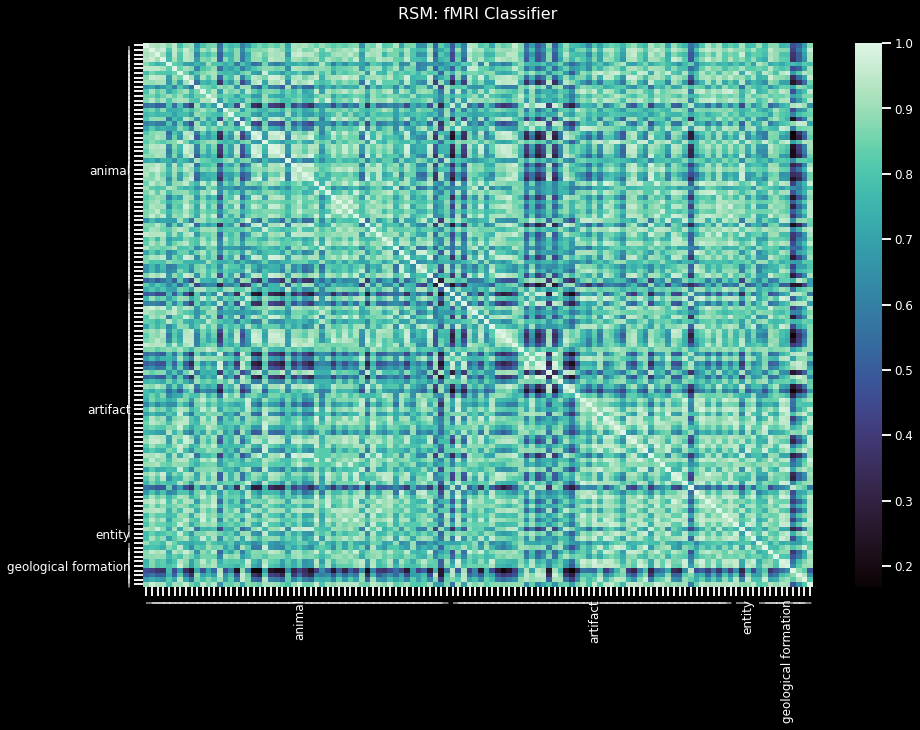

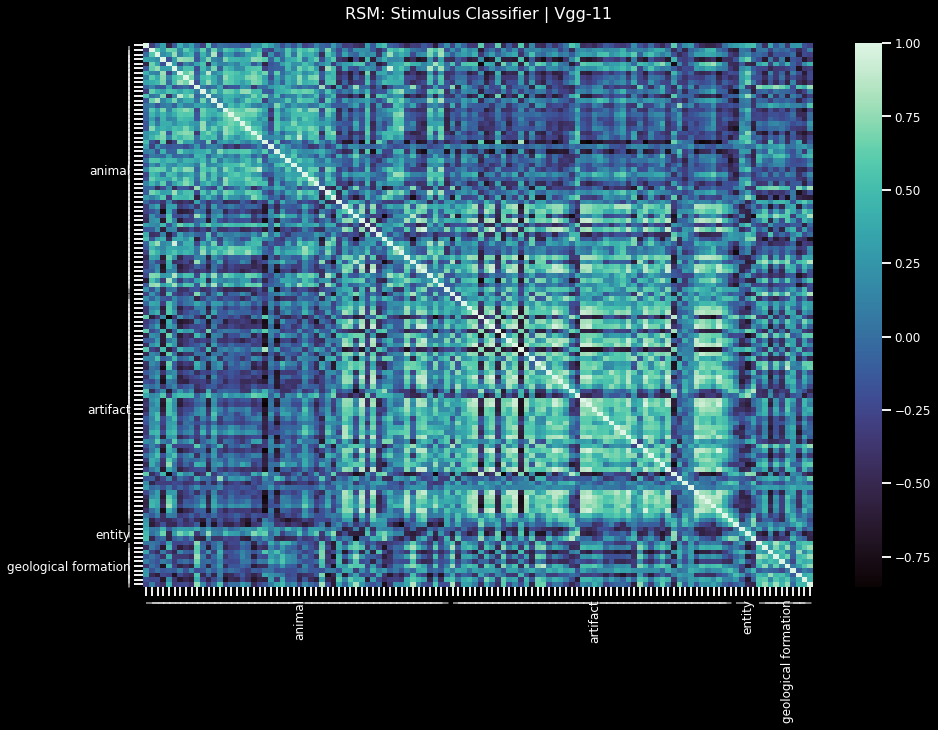

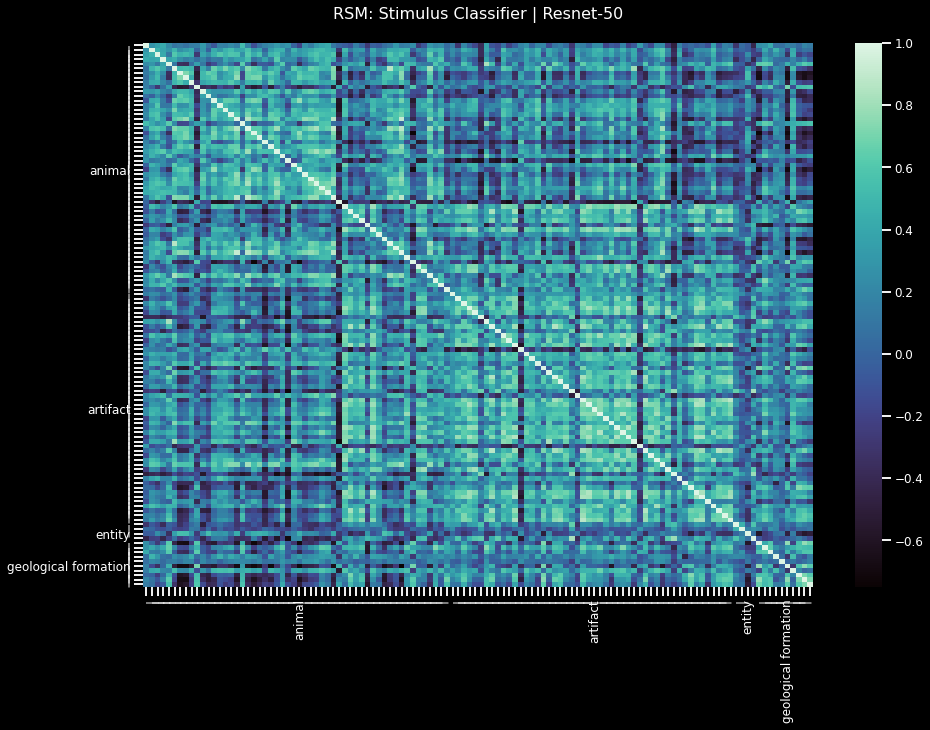

In [8]:
run_rsa(
    fmri_model=fmri_model,
    fmri_loader=fmri_loader,
    fmri_config=fmri_config,
    stim_loader=stim_loader,
    stim_config = stim_config,
    class2idx=class2idx,
    idx2class=idx2class,
)